In [27]:
%load_ext dotenv
%dotenv
import openai
import re
import requests
import json
from pprint import pprint
import os
import pandas as pd
import numpy as np
from openai.embeddings_utils import get_embedding, cosine_similarity
from transformers import GPT2TokenizerFast
from bs4 import BeautifulSoup
from pprint import pprint
from selenium import webdriver
from IPython.core.display import display



API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")
RESOURCE_ENDPOINT = os.environ.get("AZURE_OPENAI_ENDPOINT") # https://example-endpoint.openai.azure.com - for direct openAI

openai.api_type = "azure"
openai.api_key = API_KEY
openai.api_base = RESOURCE_ENDPOINT
openai.api_version = "2022-12-01"
url = openai.api_base + "/openai/deployments?api-version=2022-12-01"

r = requests.get(url, headers={"api-key": API_KEY})

print(r.text)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


/var/folders/1r/yhjv8kgd5vgdzbmygdjstqgc0000gn/T/ipykernel_97200/227551377.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


{
  "data": [
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "text-ada-001",
      "owner": "organization-owner",
      "id": "Ada1",
      "status": "succeeded",
      "created_at": 1676559783,
      "updated_at": 1676559783,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "text-embedding-ada-002",
      "owner": "organization-owner",
      "id": "embedding-model",
      "status": "succeeded",
      "created_at": 1676563276,
      "updated_at": 1676563276,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      "model": "text-davinci-003",
      "owner": "organization-owner",
      "id": "davinchi-003",
      "status": "succeeded",
      "created_at": 1676563605,
      "updated_at": 1676563605,
      "object": "deployment"
    },
    {
      "scale_settings": {
        "scale_type": "standard"
      },
      

'<html class="a-js a-audio a-video a-canvas a-svg a-drag-drop a-geolocation a-history a-webworker a-autofocus a-input-placeholder a-textarea-placeholder a-local-storage a-gradients a-hires a-transform3d -scrolling a-text-shadow a-text-stroke a-box-shadow a-border-radius a-border-image a-opacity a-transform a-transition null" data-19ax5a9jf="dingo" data-aui-build-date="3.23.1-2023-04-26" lang="en-us">\n <!-- sp:feature:head-start -->\n <head>\n  <script async="" crossorigin="anonymous" src="https://images-na.ssl-images-amazon.com/images/I/31bJewCvY-L.js">\n  </script>\n  <style class="vjs-styles-defaults">\n   .video-js {\n        width: 300px;\n        height: 150px;\n      }\n\n      .vjs-fluid {\n        padding-top: 56.25%\n      }\n  </style>\n  <style class="vjs-styles-dimensions">\n   .detail-player-829b7f44-9c14-4ee1-95be-f5e7c56f8a5d-container-element-dimensions {\n        width: 300px;\n        height: 168.75px;\n      }\n\n      .detail-player-829b7f44-9c14-4ee1-95be-f5e7c56f
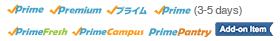

'********************************************************'

In [23]:
selenium_url = 'https://www.adidas.com/us/samba-vegan-x-disney-mickey-shoes/GY1889.html'
# selenium_url = "https://www.amazon.com/Redragon-S101-Keyboard-Ergonomic-Programmable/dp/B00NLZUM36/ref=sr_1_1_sspa?keywords=gaming+keyboard&pd_rd_r=0aca389c-dc43-43c8-a79c-bbf8c422e270&pd_rd_w=o70iX&pd_rd_wg=OLv4Z&pf_rd_p=12129333-2117-4490-9c17-6d31baf0582a&pf_rd_r=VJFQ47GKGSWP1G2RXENN&qid=1682795029&sr=8-1-spons&psc=1&spLa=ZW5jcnlwdGVkUXVhbGlmaWVyPUExRUgyR09EUTQzV1cmZW5jcnlwdGVkSWQ9QTAyNjcwNTUyNDdUN09aTjgwVzNCJmVuY3J5cHRlZEFkSWQ9QTA3ODkwNjYyMlpIUUM2VEpJV0RGJndpZGdldE5hbWU9c3BfYXRmJmFjdGlvbj1jbGlja1JlZGlyZWN0JmRvTm90TG9nQ2xpY2s9dHJ1ZQ=="
driver = webdriver.Chrome()
driver.get(selenium_url)
soup = BeautifulSoup(driver.page_source, 'html.parser')
display(soup.prettify())
display("********************************************************")
scripts = soup.find_all('script')

In [ ]:
for script in scripts:
    # print(f"len(script.text)={len(script.text)}")
    # n_tokens = len(tokenizer.encode(script.text))
    # print(f"n_tokens={n_tokens}")
    print("************************input text********************************")
    print(script.text)
    prompt = f"""You are a website scrapper that is looking for products and prices in scripts in html. 
    find the products and details about the products (sizes, colors, etc...) and price. when you find a product, create a dictionaries with the following format:

    {{
        "products": [
            {{
                "product" {{
                    "product name": <product name>,
                    "product price": <product price>,
                    "product category": <product category such as shoes, jackets, etc...>,
                    "product details": {{
                        "size": <product sizes options>,
                        "color": <product color>,
                        etc...
                    }}
                }},
                ...
            }}
        ],
        "python code": <here put a python script that will generate the "product" dict above. the python code should be a function called parse_product(text) that returns the "products" list>
        
    }}
    Mention if any of the details affect the price of the product. if there is no products in the text, put an empty list in the products field and an empty string in the python code value.
    find in the following script: 
    {script.text}"""
    
    try:
        response = openai.Completion.create(engine="davinchi-003", prompt=prompt, max_tokens=1024)
        # response = openai.ChatCompletion.create(
        #     engine="gpt-35-turbo",
        #     messages = [
        #             {"role": "system", "content": "you are a website scrapper that is looking for products and prices in scripts in html. find the products and details about the products (sizes, colors, etc...) and price. when you find a product, create a dictionaries with the following format:"},
        #             {"role": "user", "content": script.text}
        #         ],
        #     temperature=0.7,
        #     max_tokens=800,
        #     top_p=0.95,
        #     frequency_penalty=0,
        #     presence_penalty=0,
        #     stop=None
        # )
        
        print(response.choices[0].text)
        text = response['choices'][0]['text']
        usage = response["usage"]

        print("************************result********************************")
        print(text)
        pprint(usage)
       
    except Exception as e:
        print(e) 


In [26]:
html_text = soup.text
state = ""
product = ""
batch_size=3000
tokens = 0
for batch in range(0, len(html_text), batch_size):
    batch = html_text[batch:batch+batch_size]
    print("next batch...")
    # print("************************input text********************************")
    # print(batch)
    prompt = f"""You are a website scrapper that is looking for the main product at that is presented in the html. Your job is to find all the details of a product from its html page. 
    I will stream you the html page with batchs of 1000 characters int the following json format:
    {{
        "html": <html batch>,
        "state": <relevant information from previous batches that you need inorder to update the "prodct" details>,
        "product" {{
            "product name": "<product name>",
            "product anotations": [
                {{
                    "price": <price as a number and currency mark, if not found, put -1>,
                    "size": "<size>",
                    "color": "<color>",
                    etc...
                }}
            ]
        }},
        batch_size: 1000
    }}
    and you will return the the following json format:
    {{
        "product" {{
            "product name": <product name>,
            "product anotations": [
                {{
                    "price": <price>,
                    "size": <size>,
                    "color": <color>,
                    etc...
                }}
            ]
        }},
        "batch summary": <summary of the batch, what it consists of>,
        "state": <relevant information that you need to save from previous batches to complete the information about the product.>
    }}

    write only the json object string without any strings before or after the json string so it can be parsed by json library without any string before the first {{ and after the }} and dont write output: at the begining of the response.
    
    input batch for next iteration:
    {{
        "html": {batch},
        "state": {state},
        "product" {product},
        batch_size: {batch_size}
    }}
    """
    
    try:
        response = openai.Completion.create(engine="davinchi-003", prompt=prompt, max_tokens=1024, temperature=0)
        # response = openai.ChatCompletion.create(
        #     engine="gpt-35-turbo",
        #     messages = [
        #             {"role": "system", "content": "you are a website scrapper that is looking for products and prices in scripts in html. find the products and details about the products (sizes, colors, etc...) and price. when you find a product, create a dictionaries with the following format:"},
        #             {"role": "user", "content": script.text}
        #         ],
        #     temperature=0.7,
        #     max_tokens=800,
        #     top_p=0.95,
        #     frequency_penalty=0,
        #     presence_penalty=0,
        #     stop=None
        # )
        
        print(response['choices'][0]['text'])
        json_response = json.loads(response['choices'][0]['text'])
        state = json_response["state"]
        product = json_response["product"]
        usage = response["usage"]
        print(f"state={state} product={product}") 
        # input("press enter to continue")
        print("************************result********************************")
        pprint(usage)
        tokens += usage["total_tokens"]
    except Exception as e:
        print(e) 
result = f"""
The product in the page is {product["product name"]} and it has the following details:
{product}"""
pprint(result)
print(f"total tokens={tokens}.\n") 

price_turbo = tokens/1000*0.002
print(f"price={price_turbo}$/page for the turbo model")
# in the prints show the prices with only 2 digits after the decimal point.
print(f"price for 700,000,000 pages is {(price_turbo*700000000)/1000000:.2f}M$")
print(f"price for 4,000,000,000 pages is {(price_turbo*4000000000)/1000000:.2f}M$")


next batch...

{"product": {"product name": "Redragon S101 Wired Gaming Keyboard and Mouse Combo RGB Backlit Gaming Keyboard with Multimedia Keys Wrist Rest and Red Backlit Gaming Mouse 3200 DPI for Windows PC Gamers (Black)", "product anotations": [{"price": "$39.99", "size": "", "color": "", "shipping": "$17.17", "estimated import fees deposit": "$0.00", "total": "$57.16"}]}, "batch summary": "The batch consists of the product name, price, shipping and estimated import fees deposit and total.", "state": ""}
state= product={'product name': 'Redragon S101 Wired Gaming Keyboard and Mouse Combo RGB Backlit Gaming Keyboard with Multimedia Keys Wrist Rest and Red Backlit Gaming Mouse 3200 DPI for Windows PC Gamers (Black)', 'product anotations': [{'price': '$39.99', 'size': '', 'color': '', 'shipping': '$17.17', 'estimated import fees deposit': '$0.00', 'total': '$57.16'}]}
************************result********************************
<OpenAIObject at 0x283698b30> JSON: {
  "completion_to